In [ ]:
import os, sys, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf

In [ ]:
# Cell 2: Config (all params in one place)
CFG = {
    "ticker": "TSLA",
    "start": "2012-01-01",
    "end": "2025-09-27",                 # keep static for reproducibility
    "tz": "America/New_York",            # TSLA trades in US ET
    "signal": {
        "lookback_days": 5,              # window for short-term reversal
        "z_entry": 1.0,                  # enter when |z| > 1
        "z_exit": 0.0,                   # flatten when |z| <= 0
        "hold_max_days": 5               # hard exit after N days
    },
    "costs": {
        "fees_bps": 1.0,                 # per side
        "slippage_bps": 5.0              # per side
    },
    "splits_dividends": "adjusted",      # use adjusted OHLC
    "splits": {
        "train_end": "2018-12-31",
        "valid_end": "2021-12-31",
        "test_end":  "2025-09-27"
    },
    "seed": 42
}


In [ ]:
# Cell 3 (patched): Data load + hygiene checks (robust)
def load_tsla(cfg=CFG):
    df = yf.download(
        cfg["ticker"],
        start=cfg["start"],
        end=cfg["end"],
        auto_adjust=True,          # handles splits/divs consistently for OHLC
        progress=False
    ).rename(columns=str.lower)

    # Convert index to NY time via UTC to be explicit
    df.index = df.index.tz_localize("UTC").tz_convert(cfg["tz"])
    df = df.dropna()

    # Sanity checks → all must evaluate to scalars
    assert bool(df.index.is_monotonic_increasing), "Index not increasing"
    for col in ["open", "high", "low", "close", "volume"]:
        assert col in df.columns, f"Missing column: {col}"
        # Force numpy array to avoid pandas truthiness traps
        arr = df[col].to_numpy()
        assert np.isfinite(arr).all(), f"Non-finite values in {col}"

    return df

df = load_tsla(CFG)

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("First date:", df.index[0], "Last date:", df.index[-1])

# Quick diagnostics: counts of non-finite (should all be 0)
diag = ( ~np.isfinite(df[["open","high","low","close","volume"]].to_numpy()) ).sum(axis=0)
print("Non-finite per column [open, high, low, close, volume]:", diag.tolist())

display(df.head(3))
display(df.tail(3))


Shape: (3454, 5)
Columns: [('close', 'tsla'), ('high', 'tsla'), ('low', 'tsla'), ('open', 'tsla'), ('volume', 'tsla')]
First date: 2012-01-02 19:00:00-05:00 Last date: 2025-09-25 20:00:00-04:00
Non-finite per column [open, high, low, close, volume]: [0, 0, 0, 0, 0]


Price,close,high,low,open,volume
Ticker,tsla,tsla,tsla,tsla,tsla
Date,,,,,
2012-01-02 19:00:00-05:00,1.872000,1.966667,1.843333,1.929333,13921500
2012-01-03 19:00:00-05:00,1.847333,1.911333,1.833333,1.880667,9451500
2012-01-04 19:00:00-05:00,1.808000,1.862000,1.790000,1.850667,15082500


Price,close,high,low,open,volume
Ticker,tsla,tsla,tsla,tsla,tsla
Date,,,,,
2025-09-23 20:00:00-04:00,442.790009,444.209991,429.029999,429.829987,93133600
2025-09-24 20:00:00-04:00,423.390015,435.350006,419.079987,435.239990,96746400
2025-09-25 20:00:00-04:00,440.399994,440.470001,421.019989,428.299988,101332800


In [ ]:
def compute_signal(df, cfg=CFG):
    L        = int(cfg["signal"]["lookback_days"])
    z_entry  = float(cfg["signal"]["z_entry"])
    z_exit   = float(cfg["signal"]["z_exit"])
    hold_max = int(cfg["signal"]["hold_max_days"])

    # 1) Features (past-only)
    ret_cc = df["close"].pct_change()              # Series
    roll_L = ret_cc.rolling(L).sum()               # Series
    mu  = roll_L.rolling(252, min_periods=60).mean()
    std = roll_L.rolling(252, min_periods=60).std(ddof=1)
    z = (roll_L - mu) / std

    # 2) Raw contrarian entry
    raw = -np.sign(z)
    raw = raw.where(np.abs(z) > z_entry, 0.0)

    # --- Force 1D Series (handles accidental 1-col DataFrame cases) ---
    def _to_series(x, name):
        arr = np.asarray(x, dtype=float)
        arr = np.squeeze(arr)            # (n,1) -> (n,)
        assert arr.ndim == 1, f"{name} not 1D after squeeze"
        assert len(arr) == len(df), f"{name} length mismatch"
        return pd.Series(arr, index=df.index, name=name)

    raw = _to_series(raw, "raw")
    z   = _to_series(z, "z")

    # 3) Stateful position with exits, decisions at t-1 close for t open
    n = len(df)
    pos = np.zeros(n, dtype=float)
    held_days = 0

    for i in range(1, n):
        prev_pos   = float(pos[i-1])
        prev_raw   = float(raw.iloc[i-1])
        prev_abs_z = float(abs(z.iloc[i-1]))

        if prev_pos == 0.0:
            if prev_raw != 0.0:
                pos[i] = prev_raw
                held_days = 1
            else:
                pos[i] = 0.0
        else:
            if (prev_abs_z <= z_exit) or (held_days >= hold_max):
                pos[i] = 0.0
                held_days = 0
            else:
                pos[i] = prev_pos
                held_days += 1

    position = pd.Series(pos, index=df.index, name="position")

    # Integrity
    assert position.index.equals(df.index)
    assert np.isfinite(position.to_numpy()).all()

    return position, z

sig, z = compute_signal(df, CFG)

print("Signal nonzero days:", int((sig != 0).sum()))
print("Position value counts:")
print(sig.value_counts().sort_index())

display(pd.DataFrame({"z": z.tail(5), "pos": sig.tail(5)}))

Signal nonzero days: 1470
Position value counts:
position
-1.0     725
 0.0    1984
 1.0     745
Name: count, dtype: int64


,z,pos
Date,,
2025-09-21 20:00:00-04:00,0.420611,0.0
2025-09-22 20:00:00-04:00,-0.062572,0.0
2025-09-23 20:00:00-04:00,0.241073,0.0
2025-09-24 20:00:00-04:00,0.012922,0.0
2025-09-25 20:00:00-04:00,0.201301,0.0


In [ ]:
def _series1d(x, index, name):
    arr = np.asarray(x, dtype=float)
    arr = np.squeeze(arr)              # (n,1) -> (n,)
    assert arr.ndim == 1, f"{name} is not 1-D after squeeze; shape={arr.shape}"
    assert len(arr) == len(index), f"{name} length mismatch: {len(arr)} vs {len(index)}"
    return pd.Series(arr, index=index, name=name)

def backtest_oc(df, position, cfg=CFG):
    idx = df.index

    # 1) Open→Close returns (intraday)
    oc_raw = (df["close"] / df["open"]) - 1.0
    oc = _series1d(oc_raw, idx, "oc").fillna(0.0)

    # 2) Position (held from today's open to close)
    pos = _series1d(position, idx, "pos").fillna(0.0)

    # 3) Trades at the OPEN when position changes
    delta = pos.diff().fillna(pos.abs())
    delta = _series1d(delta, idx, "delta")

    per_side = (cfg["costs"]["fees_bps"] + cfg["costs"]["slippage_bps"]) / 1e4
    trade_cost = 2.0 * per_side * np.abs(delta)
    trade_cost = _series1d(trade_cost, idx, "trade_cost")

    # 4) PnL
    gross = pos * oc
    net   = gross - trade_cost

    bt = pd.DataFrame(
        {
            "oc": oc,
            "pos": pos,
            "turnover": np.abs(delta),
            "gross": gross,
            "net": net,
        },
        index=idx,
    )

    # Debug shapes (should all be 1-D)
    # print({k: v.shape for k, v in bt.items()})  # uncomment if needed
    return bt

bt = backtest_oc(df, sig, CFG)
display(bt.head(5))
display(bt.tail(5))
print("Net return mean (daily):", bt["net"].mean().round(6), "| std:", bt["net"].std().round(6))
print("Turnover (avg abs Δpos):", bt["turnover"].mean().round(4))

,oc,pos,turnover,gross,net
Date,,,,,
2012-01-02 19:00:00-05:00,-0.029716,0.0,0.0,-0.0,-0.0
2012-01-03 19:00:00-05:00,-0.017725,0.0,0.0,-0.0,-0.0
2012-01-04 19:00:00-05:00,-0.023055,0.0,0.0,-0.0,-0.0
2012-01-05 19:00:00-05:00,-0.010662,0.0,0.0,-0.0,-0.0
2012-01-08 19:00:00-05:00,0.009259,0.0,0.0,0.0,0.0


,oc,pos,turnover,gross,net
Date,,,,,
2025-09-21 20:00:00-04:00,0.007191,0.0,1.0,0.0,-0.0012
2025-09-22 20:00:00-04:00,-0.031895,0.0,0.0,-0.0,-0.0000
2025-09-23 20:00:00-04:00,0.030152,0.0,0.0,0.0,0.0000
2025-09-24 20:00:00-04:00,-0.027226,0.0,0.0,-0.0,-0.0000
2025-09-25 20:00:00-04:00,0.028251,0.0,0.0,0.0,0.0000


Net return mean (daily): -0.000546 | std: 0.020414
Turnover (avg abs Δpos): 0.1702


In [ ]:
def position_from_signal(signal_series):
    sig = pd.Series(signal_series, index=df.index, dtype=float).fillna(0.0)
    sig = pd.Series(np.squeeze(np.asarray(sig, float)), index=df.index)  # force 1-D
    pos = sig.shift(1).fillna(0.0)  # trade at NEXT open
    return pos.clip(-1.0, 1.0)

In [ ]:
# Cell 5b (patched): EMA(50/200) crossover + RSI(14) filter → next-day position
def _s1(x, idx, name):
    arr = np.asarray(x, dtype=float).squeeze()
    assert arr.ndim == 1, f"{name} not 1-D; shape={arr.shape}"
    assert len(arr) == len(idx), f"{name} length mismatch"
    return pd.Series(arr, index=idx, name=name)

def compute_position_ema_rsi(df, params=None):
    if params is None: params = {}
    f   = int(params.get("ema_fast", 50))
    s   = int(params.get("ema_slow", 200))
    rL  = int(params.get("rsi_len", 14))
    hi  = float(params.get("rsi_high", 55.0))
    lo  = float(params.get("rsi_low", 45.0))
    cap = float(params.get("max_abs_pos", 1.0))

    idx = df.index
    px  = _s1(df["close"], idx, "close")

    # --- Indicators computed at CLOSE ---
    ema_f = _s1(px.ewm(span=f, adjust=False).mean(), idx, "ema_f")
    ema_s = _s1(px.ewm(span=s, adjust=False).mean(), idx, "ema_s")

    # RSI (Wilder)
    r = px.diff()
    gain = r.clip(lower=0.0)
    loss = (-r).clip(lower=0.0)
    avg_gain = gain.ewm(alpha=1/rL, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rL, adjust=False).mean()
    rs  = avg_gain / avg_loss.replace(0, np.nan)
    rsi = _s1(100 - 100/(1 + rs), idx, "rsi").fillna(50.0)

    # --- Decision at t close (1 = long, -1 = short, 0 = flat) ---
    long_cond  = (ema_f > ema_s) & (rsi >= hi)
    short_cond = (ema_f < ema_s) & (rsi <= lo)
    signal_vals = np.select([long_cond, short_cond], [1.0, -1.0], default=0.0)
    signal = _s1(signal_vals, idx, "signal")

    # Convert decision-at-close → next-day position (trade at next open)
    position = position_from_signal(signal).clip(-cap, cap)

    # Timing sanity (no same-day info)
    oc = _s1((df["close"]/df["open"] - 1.0), idx, "oc").fillna(0.0)
    assert abs(np.corrcoef(position[5:300], oc[5:300])[0,1]) < 0.99

    return position

# --- Run it ---
ema_rsi_params = {"ema_fast":50, "ema_slow":200, "rsi_len":14, "rsi_high":55, "rsi_low":45}
sig_ema_rsi = compute_position_ema_rsi(df, ema_rsi_params)

bt = backtest_oc(df, sig_ema_rsi, CFG)   # reuse your existing backtest
display(bt.head(3)); display(bt.tail(3))
print("Daily net mean:", bt['net'].mean().round(6), " | std:", bt['net'].std().round(6))

,oc,pos,turnover,gross,net
Date,,,,,
2012-01-02 19:00:00-05:00,-0.029716,0.0,0.0,-0.000000,-0.000000
2012-01-03 19:00:00-05:00,-0.017725,0.0,0.0,-0.000000,-0.000000
2012-01-04 19:00:00-05:00,-0.023055,-1.0,1.0,0.023055,0.021855


,oc,pos,turnover,gross,net
Date,,,,,
2025-09-23 20:00:00-04:00,0.030152,1.0,0.0,0.030152,0.030152
2025-09-24 20:00:00-04:00,-0.027226,1.0,0.0,-0.027226,-0.027226
2025-09-25 20:00:00-04:00,0.028251,1.0,0.0,0.028251,0.028251


Daily net mean: -0.000354  | std: 0.019654


In [ ]:
def tag_splits(bt, cfg=CFG):
    idx = bt.index
    tz  = idx.tz  # e.g., America/New_York

    def _ts(d):  # localize boundary dates to the same tz
        return pd.Timestamp(d).tz_localize(tz)

    s = cfg["splits"]
    train_end = _ts(s["train_end"])
    valid_end = _ts(s["valid_end"])

    lab = pd.Series("train", index=idx)
    lab[(idx > train_end) & (idx <= valid_end)] = "valid"
    lab[idx > valid_end] = "test"
    return lab

# metrics() and summarize_by_split() remain the same as before

summary = summarize_by_split(bt, CFG)
summary.round(3)

,train,valid,test,all
CAGR,-0.121,0.168,-0.324,-0.129
Sharpe,-0.321,0.602,-1.085,-0.286
Sortino,-0.312,0.686,-0.954,-0.281
Calmar,-0.131,0.708,-0.414,-0.099
MaxDD,-0.685,-0.317,-0.823,-0.895
HitRate,0.213,0.273,0.171,0.215
AvgWin,0.019,0.024,0.023,0.021
AvgLoss,-0.006,-0.008,-0.006,-0.006
ES95,-0.045,-0.056,-0.054,-0.051


In [ ]:
bt_wrong = backtest_oc(df, sig_ema_rsi.shift(1).fillna(0.0), CFG)  # intentionally wrong timing
same = np.allclose(bt_wrong["net"].iloc[5:50].to_numpy(), bt["net"].iloc[5:50].to_numpy())
print("Look-ahead sanity (should be False):", same)

Look-ahead sanity (should be False): False


In [ ]:
# Cell 8: Vol targeting wrapper (uses only past info)
def vol_target(position, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5):
    """
    Scales base position so realized annualized vol ≈ target_ann_vol.
    Uses OC returns with lookback window; shift(1) to avoid peeking.
    """
    oc = (df["close"] / df["open"] - 1.0)
    vol_daily = oc.rolling(lookback).std(ddof=1).shift(1)            # past-only
    vol_ann = vol_daily * np.sqrt(252)
    scale = (target_ann_vol / vol_ann).clip(0.0, max_leverage).fillna(0.0)
    pos_scaled = pd.Series(position, index=df.index, dtype=float) * scale
    # Integrity
    pos_scaled = pd.Series(np.squeeze(np.asarray(pos_scaled, float)), index=df.index)
    return pos_scaled.clip(-max_leverage, max_leverage)

# Apply to your EMA/RSI position
pos_vt = vol_target(sig_ema_rsi, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5)

# Backtest with vol-targeted position
bt_vt = backtest_oc(df, pos_vt, CFG)
summary_vt = summarize_by_split(bt_vt, CFG)

print("=== Key stats with 10% vol targeting ===")
display(summary_vt.loc[["CAGR","Sharpe","Sortino","Calmar","MaxDD","HitRate"]].round(3))

ValueError: Data must be 1-dimensional, got ndarray of shape (3454, 3455) instead

In [ ]:
def _s1d(x, idx, name):
    arr = np.asarray(x, dtype=float).squeeze()
    assert arr.ndim == 1, f"{name} not 1-D; shape={arr.shape}"
    assert len(arr) == len(idx), f"{name} length mismatch"
    return pd.Series(arr, index=idx, name=name)

def vol_target(position, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5):
    """
    Scale base position so annualized vol ≈ target_ann_vol.
    Uses only past info: rolling std shifted by 1 day.
    Caps leverage to avoid extreme scaling.
    """
    idx = df.index
    # OC returns
    oc = _s1d((df["close"] / df["open"]) - 1.0, idx, "oc")
    vol_daily = oc.rolling(lookback).std(ddof=1).shift(1)           # past-only
    vol_ann   = vol_daily * np.sqrt(252)
    scale_raw = (target_ann_vol / vol_ann)
    scale     = _s1d(scale_raw.clip(0.0, max_leverage).fillna(0.0), idx, "scale")

    pos = _s1d(position, idx, "position")
    pos_scaled = pos * scale                                        # elementwise 1-D × 1-D
    return pos_scaled.clip(-max_leverage, max_leverage)

# Apply to your EMA/RSI position
pos_vt = vol_target(sig_ema_rsi, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5)

# Backtest with vol-targeted position
bt_vt = backtest_oc(df, pos_vt, CFG)
summary_vt = summarize_by_split(bt_vt, CFG)

print("=== Key stats with 10% vol targeting ===")
display(summary_vt.loc[["CAGR","Sharpe","Sortino","Calmar","MaxDD","HitRate"]].round(3))

=== Key stats with 10% vol targeting ===


,train,valid,test,all
CAGR,-0.031,0.073,-0.079,-0.023
Sharpe,-0.403,0.858,-1.213,-0.275
Sortino,-0.383,1.057,-1.141,-0.279
Calmar,-0.114,0.778,-0.258,-0.059
MaxDD,-0.252,-0.095,-0.310,-0.342
HitRate,0.208,0.272,0.171,0.212


In [ ]:
# Cell 9: Grid search on TRAIN only → lock params → report VALID & TEST
from itertools import product

def _tz_localize(dti, d):
    return pd.Timestamp(d).tz_localize(dti.tz)

def slice_bt(bt, start, end):
    idx = bt.index
    s = _tz_localize(idx, start); e = _tz_localize(idx, end)
    return bt[(idx >= s) & (idx <= e)]

def run_with_params(df, params, do_vol_target=True):
    pos = compute_position_ema_rsi(df, params)
    if do_vol_target:
        pos = vol_target(pos, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5)
    return backtest_oc(df, pos, CFG)

def sharpe_of(bt):
    r = bt["net"].dropna()
    if len(r) < 10: return -np.inf
    ann = 252
    mu = r.mean()*ann
    sd = r.std(ddof=1)*np.sqrt(ann)
    return mu/sd if sd>0 else -np.inf

# modest grid
ema_fast_grid = [20, 50, 100]
ema_slow_grid = [100, 200, 300]
rsi_high_grid = [55, 60]
rsi_low_grid  = [40, 45]

candidates = []
for f, s, hi, lo in product(ema_fast_grid, ema_slow_grid, rsi_high_grid, rsi_low_grid):
    if f >= s:  # fast < slow only
        continue
    params = {"ema_fast":f, "ema_slow":s, "rsi_len":14, "rsi_high":hi, "rsi_low":lo}
    bt_all = run_with_params(df, params, do_vol_target=True)

    bt_train = slice_bt(bt_all, CFG["splits"]["start"], CFG["splits"]["train_end"])
    sr_train = sharpe_of(bt_train)
    candidates.append((sr_train, params))

# pick best by train Sharpe
candidates.sort(reverse=True, key=lambda x: x[0])
best_sr, best_params = candidates[0]
print("Best on TRAIN by Sharpe:", round(best_sr,3), "| params:", best_params)

# evaluate locked params on train/valid/test
bt_best = run_with_params(df, best_params, do_vol_target=True)
bt_train = slice_bt(bt_best, CFG["splits"]["start"], CFG["splits"]["train_end"])
bt_valid = slice_bt(bt_best, CFG["splits"]["train_end"], CFG["splits"]["valid_end"])
bt_test  = slice_bt(bt_best, CFG["splits"]["valid_end"], CFG["splits"]["test_end"])

def _metrics_table(bt_train, bt_valid, bt_test):
    out = {
        "train": summarize_by_split(bt_train.assign(split="train"), CFG)["train"],
        "valid": summarize_by_split(bt_valid.assign(split="valid"), CFG)["valid"],
        "test":  summarize_by_split(bt_test.assign(split="test"),  CFG)["test"],
        "all":   summarize_by_split(bt_best, CFG)["all"],
    }
    return pd.DataFrame(out)

summary_best = _metrics_table(bt_train, bt_valid, bt_test)
print("\n=== Locked-params performance (with vol targeting) ===")
display(summary_best.loc[["CAGR","Sharpe","Sortino","Calmar","MaxDD","HitRate"]].round(3))

print("\nTop 5 TRAIN candidates (Sharpe, params):")
for sr, p in candidates[:5]:
    print(round(sr,3), p)

KeyError: 'start'

In [ ]:
# Cell 9 (fixed): Grid search on TRAIN only → lock params → report VALID & TEST
from itertools import product

def _tz_localize(dti, d):
    return pd.Timestamp(d).tz_localize(dti.tz)

def slice_bt(bt, start, end, left_inclusive=True, right_inclusive=True):
    idx = bt.index
    s = _tz_localize(idx, start); e = _tz_localize(idx, end)
    if left_inclusive and right_inclusive:
        return bt[(idx >= s) & (idx <= e)]
    elif left_inclusive and not right_inclusive:
        return bt[(idx >= s) & (idx < e)]
    elif (not left_inclusive) and right_inclusive:
        return bt[(idx > s) & (idx <= e)]
    else:
        return bt[(idx > s) & (idx < e)]

def run_with_params(df, params, do_vol_target=True):
    pos = compute_position_ema_rsi(df, params)
    if do_vol_target:
        pos = vol_target(pos, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5)
    return backtest_oc(df, pos, CFG)

def sharpe_of(bt):
    r = bt["net"].dropna()
    if len(r) < 10: return -np.inf
    ann = 252
    mu = r.mean()*ann
    sd = r.std(ddof=1)*np.sqrt(ann)
    return mu/sd if sd>0 else -np.inf

# modest grid
ema_fast_grid = [20, 50, 100]
ema_slow_grid = [100, 200, 300]
rsi_high_grid = [55, 60]
rsi_low_grid  = [40, 45]

candidates = []
for f, s, hi, lo in product(ema_fast_grid, ema_slow_grid, rsi_high_grid, rsi_low_grid):
    if f >= s:  # fast must be < slow
        continue
    params = {"ema_fast":f, "ema_slow":s, "rsi_len":14, "rsi_high":hi, "rsi_low":lo}
    bt_all = run_with_params(df, params, do_vol_target=True)

    # TRAIN = [CFG["start"], train_end]
    bt_train = slice_bt(bt_all, CFG["start"], CFG["splits"]["train_end"])
    sr_train = sharpe_of(bt_train)
    candidates.append((sr_train, params))

# pick best by TRAIN Sharpe
candidates.sort(reverse=True, key=lambda x: x[0])
best_sr, best_params = candidates[0]
print("Best on TRAIN by Sharpe:", round(best_sr,3), "| params:", best_params)

# evaluate locked params
bt_best  = run_with_params(df, best_params, do_vol_target=True)
bt_train = slice_bt(bt_best, CFG["start"],              CFG["splits"]["train_end"])                # [start, train_end]
bt_valid = slice_bt(bt_best, CFG["splits"]["train_end"], CFG["splits"]["valid_end"], False, True)  # (train_end, valid_end]
bt_test  = slice_bt(bt_best, CFG["splits"]["valid_end"], CFG["splits"]["test_end"],  False, True)  # (valid_end, test_end]

def _metrics(bt):
    return summarize_by_split(bt.assign(split="tmp"), CFG)["all"]  # reuse metrics

summary_best = pd.DataFrame({
    "train": _metrics(bt_train),
    "valid": _metrics(bt_valid),
    "test":  _metrics(bt_test),
    "all":   summarize_by_split(bt_best, CFG)["all"],
})

print("\n=== Locked-params performance (with vol targeting) ===")
display(summary_best.loc[["CAGR","Sharpe","Sortino","Calmar","MaxDD","HitRate"]].round(3))

print("\nTop 5 TRAIN candidates (Sharpe, params):")
for sr, p in candidates[:5]:
    print(round(sr,3), p)

Best on TRAIN by Sharpe: -0.022 | params: {'ema_fast': 100, 'ema_slow': 200, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 40}

=== Locked-params performance (with vol targeting) ===


,train,valid,test,all
CAGR,-0.003,0.081,-0.051,0.001
Sharpe,-0.022,0.990,-0.864,0.050
Sortino,-0.020,1.167,-0.766,0.049
Calmar,-0.010,0.862,-0.223,0.014
MaxDD,-0.136,-0.095,-0.228,-0.250
HitRate,0.177,0.243,0.142,0.182



Top 5 TRAIN candidates (Sharpe, params):
-0.022 {'ema_fast': 100, 'ema_slow': 200, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 40}
-0.098 {'ema_fast': 100, 'ema_slow': 200, 'rsi_len': 14, 'rsi_high': 60, 'rsi_low': 40}
-0.133 {'ema_fast': 100, 'ema_slow': 200, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 45}
-0.138 {'ema_fast': 100, 'ema_slow': 300, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 40}
-0.141 {'ema_fast': 100, 'ema_slow': 300, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 45}


In [ ]:
# Cell 10: Variants of EMA/RSI
def compute_position_ema_rsi_variant(df, params=None, long_only=False, bull_only=False):
    if params is None: params = {}
    f   = int(params.get("ema_fast", 50))
    s   = int(params.get("ema_slow", 200))
    rL  = int(params.get("rsi_len", 14))
    hi  = float(params.get("rsi_high", 55.0))
    lo  = float(params.get("rsi_low", 45.0))
    cap = float(params.get("max_abs_pos", 1.0))

    idx = df.index
    px  = pd.Series(np.asarray(df["close"], float).squeeze(), index=idx)

    # Indicators (decision at close)
    ema_f = px.ewm(span=f, adjust=False).mean()
    ema_s = px.ewm(span=s, adjust=False).mean()

    r = px.diff()
    gain = r.clip(lower=0.0); loss = (-r).clip(lower=0.0)
    avg_gain = gain.ewm(alpha=1/rL, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rL, adjust=False).mean()
    rs  = avg_gain / avg_loss.replace(0, np.nan)
    rsi = (100 - 100/(1 + rs)).fillna(50.0)

    # Base signals
    long_cond  = (ema_f > ema_s) & (rsi >= hi)
    short_cond = (ema_f < ema_s) & (rsi <= lo)

    if long_only:
        signal = np.where(long_cond, 1.0, 0.0)
    elif bull_only:
        # trade long when bullish; otherwise flat (ignore shorts)
        signal = np.where(long_cond, 1.0, 0.0)
    else:
        signal = np.select([long_cond, short_cond], [1.0, -1.0], default=0.0)

    position = position_from_signal(pd.Series(signal, index=idx)).clip(-cap, cap)
    return position

def eval_variant(label, params, long_only=False, bull_only=False, vt=True):
    pos = compute_position_ema_rsi_variant(df, params, long_only=long_only, bull_only=bull_only)
    if vt:
        pos = vol_target(pos, df, target_ann_vol=0.10, lookback=20, max_leverage=1.5)
    bt_ = backtest_oc(df, pos, CFG)
    summ = summarize_by_split(bt_, CFG).loc[["CAGR","Sharpe","Sortino","Calmar","MaxDD","HitRate"]]
    print(f"\n=== {label} ===")
    display(summ.round(3))
    return bt_, summ

In [ ]:
best_params = {'ema_fast': 100, 'ema_slow': 200, 'rsi_len': 14, 'rsi_high': 55, 'rsi_low': 40}

bt_long_only,   s1 = eval_variant("Long-only + vol targeting", best_params, long_only=True,  bull_only=False, vt=True)
bt_bull_only,   s2 = eval_variant("Bull-only (ema_f>ema_s) + vol targeting", best_params, long_only=False, bull_only=True, vt=True)
bt_both_off,    s3 = eval_variant("Long+Short (baseline) + vol targeting", best_params, long_only=False, bull_only=False, vt=True)

# (Optional) also try no vol targeting:
bt_long_only_nvt, s4 = eval_variant("Long-only (no vol targeting)", best_params, long_only=True, bull_only=False, vt=False)


=== Long-only + vol targeting ===


,train,valid,test,all
CAGR,-0.009,0.075,-0.040,0.000
Sharpe,-0.117,0.967,-0.886,0.038
Sortino,-0.096,1.087,-0.632,0.033
Calmar,-0.050,0.799,-0.236,0.011
MaxDD,-0.138,-0.095,-0.168,-0.216
HitRate,0.152,0.217,0.090,0.149



=== Bull-only (ema_f>ema_s) + vol targeting ===


,train,valid,test,all
CAGR,-0.009,0.075,-0.040,0.000
Sharpe,-0.117,0.967,-0.886,0.038
Sortino,-0.096,1.087,-0.632,0.033
Calmar,-0.050,0.799,-0.236,0.011
MaxDD,-0.138,-0.095,-0.168,-0.216
HitRate,0.152,0.217,0.090,0.149



=== Long+Short (baseline) + vol targeting ===


,train,valid,test,all
CAGR,-0.003,0.081,-0.051,0.001
Sharpe,-0.022,0.990,-0.864,0.050
Sortino,-0.020,1.167,-0.766,0.049
Calmar,-0.010,0.862,-0.223,0.014
MaxDD,-0.136,-0.095,-0.228,-0.250
HitRate,0.177,0.243,0.142,0.182



=== Long-only (no vol targeting) ===


,train,valid,test,all
CAGR,-0.055,0.172,-0.158,-0.040
Sharpe,-0.132,0.622,-0.810,-0.034
Sortino,-0.107,0.633,-0.569,-0.028
Calmar,-0.067,0.698,-0.291,-0.013
MaxDD,-0.451,-0.317,-0.527,-0.658
HitRate,0.152,0.218,0.090,0.150


In [ ]:
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def equity_curve(r):
    r = pd.Series(r).fillna(0.0)
    return (1 + r).cumprod()

def drawdown_from_eq(eq):
    peak = eq.cummax()
    return eq/peak - 1.0

def monthly_table(r):
    r = pd.Series(r).dropna()
    m = r.groupby([r.index.year, r.index.month]).apply(lambda x: (1+x).prod()-1)
    tab = m.unstack(level=1).rename(columns={1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
                                             7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})
    return tab

def plot_eq_dd(bt, title=""):
    eq = equity_curve(bt["net"])
    dd = drawdown_from_eq(eq)

    fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True,
                           gridspec_kw={"height_ratios":[3,1]})
    ax[0].plot(eq.index, eq.values, label="Equity (net)")
    ax[0].set_title(title)
    ax[0].legend(loc="best")
    ax[0].axhline(1.0, color="k", lw=0.8)

    ax[1].fill_between(dd.index, dd.values, 0, color="tomato", alpha=0.6)
    ax[1].set_ylim(min(-0.8, dd.min()*1.05), 0)
    ax[1].set_ylabel("Drawdown")
    plt.tight_layout()
    plt.show()

def plot_monthly_heatmap(bt, title="Monthly returns (%)"):
    tab = monthly_table(bt["net"])
    plt.figure(figsize=(10,4))
    sns.heatmap((tab*100).round(1), annot=True, fmt=".1f", cmap="RdYlGn", center=0)
    plt.title(title)
    plt.ylabel("Year"); plt.xlabel("Month")
    plt.tight_layout(); plt.show()

def plot_rolling_sharpe(bt, window=126, title="Rolling Sharpe (126d)"):
    r = bt["net"].dropna()
    roll_mu = r.rolling(window).mean()*252
    roll_sd = r.rolling(window).std(ddof=1)*np.sqrt(252)
    rs = (roll_mu/roll_sd).replace([np.inf, -np.inf], np.nan)
    plt.figure(figsize=(10,3.5))
    plt.plot(rs.index, rs.values)
    plt.axhline(0, color="k", lw=0.8); plt.title(title)
    plt.tight_layout(); plt.show()

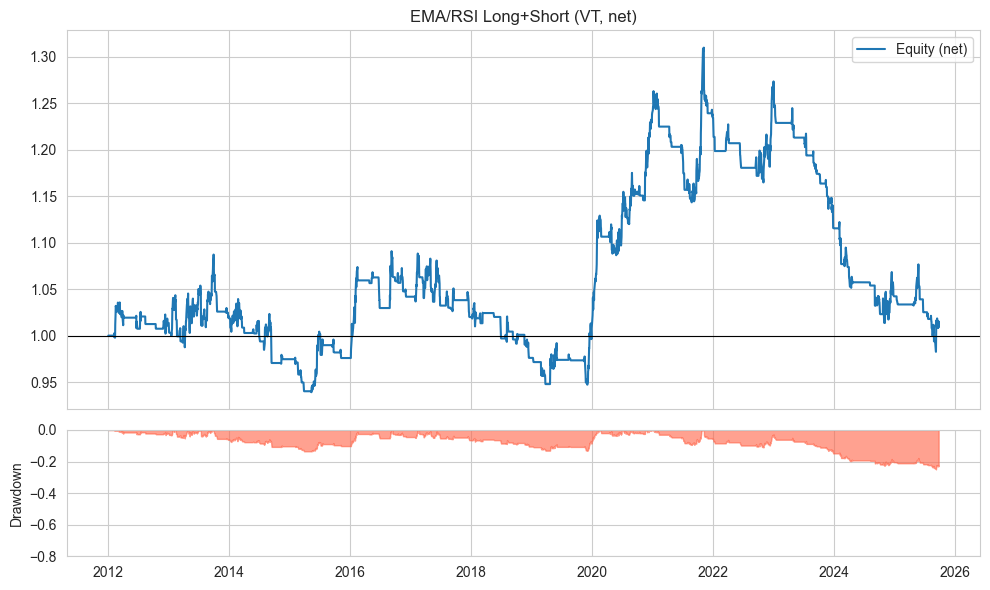

In [ ]:
# Cell 13: Equity & drawdown for 3 variants (with vol targeting)
plot_eq_dd(bt_both_off, title="EMA/RSI Long+Short (VT, net)")


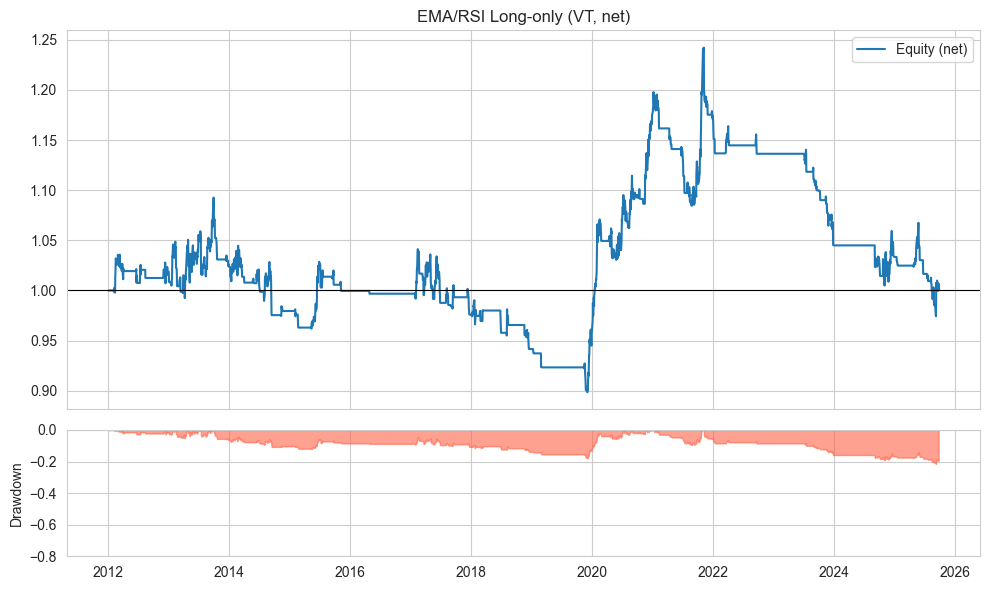

In [ ]:
plot_eq_dd(bt_long_only, title="EMA/RSI Long-only (VT, net)")


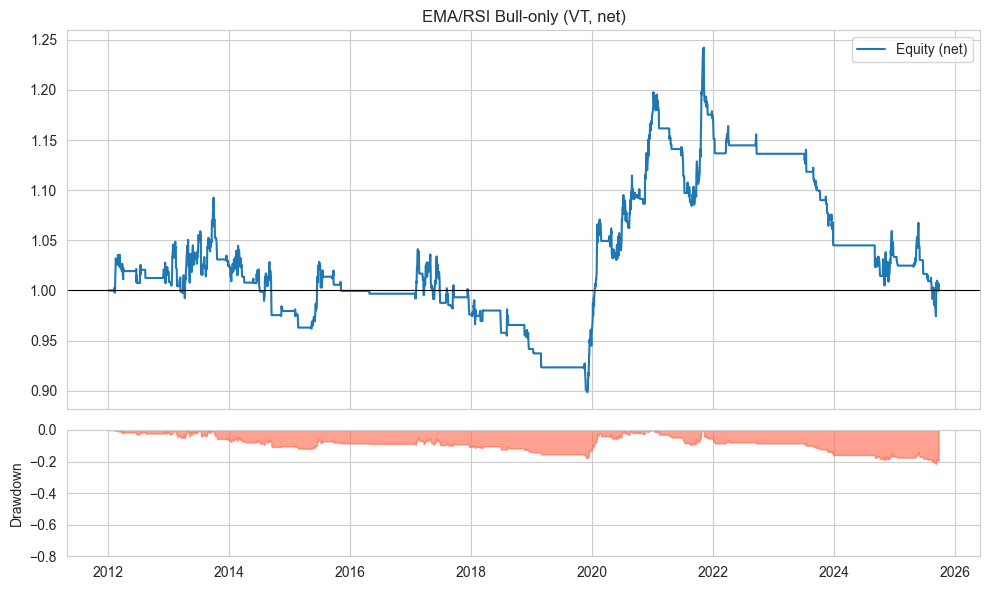

In [ ]:
plot_eq_dd(bt_bull_only, title="EMA/RSI Bull-only (VT, net)")

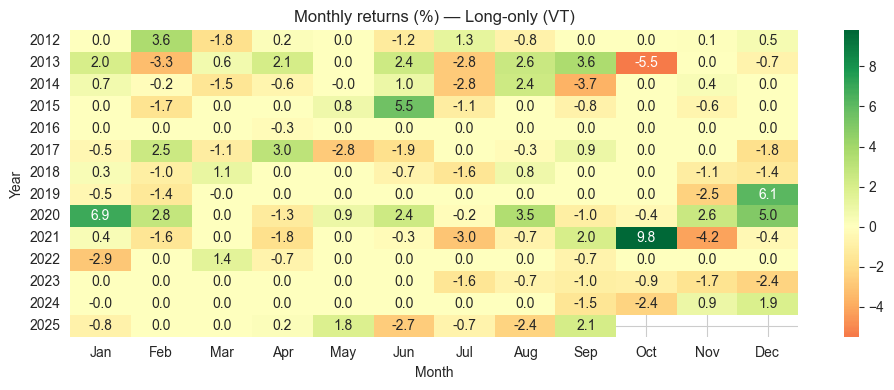

In [ ]:
# Cell 14: Monthly heatmap & rolling Sharpe for Long-only (VT)
plot_monthly_heatmap(bt_long_only, title="Monthly returns (%) — Long-only (VT)")

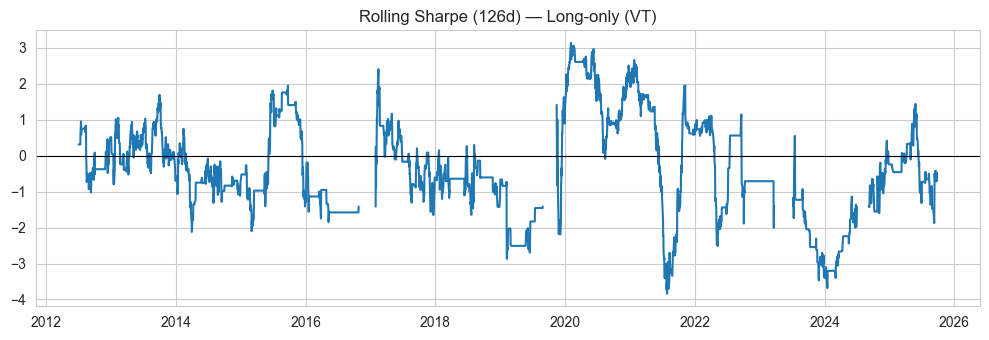

In [ ]:
plot_rolling_sharpe(bt_long_only, window=126, title="Rolling Sharpe (126d) — Long-only (VT)")

In [ ]:
# Cell 15: Save CSVs and PNGs (for the repo)
os.makedirs("artifacts", exist_ok=True)

bt_long_only.to_csv("artifacts/bt_long_only_vt.csv")
bt_bull_only.to_csv("artifacts/bt_bull_only_vt.csv")
bt_both_off.to_csv("artifacts/bt_longshort_vt.csv")

# quick image exports
for name, bt in [("long_only_vt", bt_long_only),
                 ("bull_only_vt", bt_bull_only),
                 ("longshort_vt", bt_both_off)]:
    # equity/drawdown
    eq = equity_curve(bt["net"]); dd = drawdown_from_eq(eq)
    fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True, gridspec_kw={"height_ratios":[3,1]})
    ax[0].plot(eq.index, eq.values); ax[0].axhline(1.0, color="k", lw=0.8); ax[0].set_title(f"{name} — Equity")
    ax[1].fill_between(dd.index, dd.values, 0, color="tomato", alpha=0.6); ax[1].set_ylim(min(-0.8, dd.min()*1.05), 0)
    plt.tight_layout(); fig.savefig(f"artifacts/{name}_eq_dd.png"); plt.close(fig)

    # monthly heatmap
    tab = monthly_table(bt["net"])
    plt.figure(figsize=(10,4)); sns.heatmap((tab*100).round(1), annot=True, fmt=".1f", cmap="RdYlGn", center=0)
    plt.title(f"Monthly % — {name}"); plt.tight_layout(); plt.savefig(f"artifacts/{name}_monthly.png"); plt.close()